# Computing PIV uncertainty

In [1]:
from h5rdmtoolbox.h5wrapper import H5PIV
from h5rdmtoolbox import tutorial
import numpy as np

Get an example HDF filename from the ILA vortex pair example (https://www.pivtec.com/pivview.html):

To compute the uncertainty of a PIV measurement, we need to gather some specific datasets, namely the at minimum the pixel coordinates, the displacements and the raw images. The class property `UncertaintyDataset` does this for us. Calling it will return a `xarray.Dataset` with the displacement variables.

Let's load the vortex example and fetch image A and imabe B:

In [5]:
with tutorial.get_H5PIV('vortex_snapshot', 'r+') as h5:
    disp = h5.DisplacementVector[:,:]
    imgA = h5.imgA[:,:]
    imgB = h5.imgB[:,:]
disp

<xarray.XRUncertaintyDisplacementDataset>
Dimensions:  (y: 29, x: 31)
Coordinates:
  * y        (y) float64 -464.0 -448.0 -432.0 -416.0 ... -64.0 -48.0 -32.0 -16.0
    iy       (y) int32 16 32 48 64 80 96 112 128 ... 368 384 400 416 432 448 464
  * x        (x) float64 16.0 32.0 48.0 64.0 80.0 ... 448.0 464.0 480.0 496.0
    ix       (x) int32 16 32 48 64 80 96 112 128 ... 400 416 432 448 464 480 496
    time     int32 0
    z        float64 0.0
Data variables:
    dx       (y, x) float32 nan nan nan nan nan ... 1.127 1.073 0.8495 0.7958
    dy       (y, x) float32 nan nan nan nan nan ... 0.08971 0.117 0.07952 0.1089

The uncertainty dataset has the coordinates `x` and `y`, the displacements arrays `dx` and `dy` but also the pixel coordinates `ix` and `iy`

Next, let's create a more or less random uncertainty method. In this example we do not compute the real error but assume one, just to explain the workflow of cumputing the uncertainty from the dataset:

In [6]:
def my_uncertainty_method(uds, imgA, imgB):
    """
    Dummy uncertainty method for this tutorial.
    Returns the same dataset but with added uncertainties
    
    Parameters
    ----------
    uds: XRUncertaintyDataset
        The uncertainty dataset containing, x, y, ix, iy, dx, dy, ...
    imgA: np.ndarray
        2d PIV image A. Will not be touch in this example
    imgB: np.ndarray
        2d PIV image B. Will not be touch in this example
        
    Returns
    -------
    uds: XRUncertaintyDataset    
    """
    import xarray as xr
    xerr = 0.05
    yerr = 0.075
    udx = np.abs(uds.dx)*xerr
    uds['udx'] = xr.DataArray(dims=uds.dx.dims, data=udx,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dx.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    udy = np.abs(uds.dy)*yerr
    uds['udy'] = xr.DataArray(dims=uds.dy.dims, data=udy,
                                        attrs={'standard_name': f'uncertainty_of_{uds.dy.standard_name}',
                                               'units': 'pixel',
                                               'piv_uncertainty_method': 'my_uncertainty_method'})
    return uds

In [8]:
un = disp.compute_uncertainty(my_uncertainty_method, imgA, imgB)

The `XRUncertaintyDataset` not got some more datasets and the uncertainty `DataArray` `delta_dx` and `delta_dy`

Now, let's plot the magnitude of the displacements:

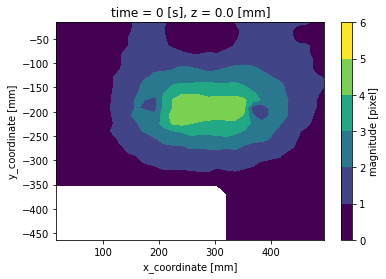

In [9]:
un.compute_magnitude()
_ = un.magnitude[:].plot.contourf(vmax=6, vmin=0)

Let's have a look at the `udx` dataset of the error without the extreme values which may be wrong:

Error in x-direction: 0.03808027505874634
Absolute relative error in x-direction: 0.05000000447034836


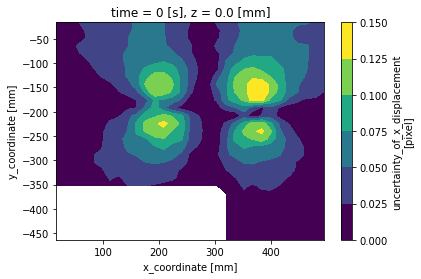

In [10]:
udx = un.get_by_sn('uncertainty_of_x_displacement')
_ = udx.where(np.abs(udx) < 20).plot.contourf()
print(f'Error in x-direction: {udx.mean().values}')
print(f'Absolute relative error in x-direction: {np.divide(udx, np.abs(u_ds.dx)).mean().values}')

In [12]:
with H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.create_group('uncertainty', overwrite=True)
    h5['uncertainty'].create_dataset('delta_dx', data=un.get_by_sn('uncertainty_of_x_displacement'), overwrite=True)
    h5['uncertainty'].create_dataset('delta_dy', data=un.get_by_sn('uncertainty_of_x_displacement'), overwrite=True)

Let's write the data into the HDF file:

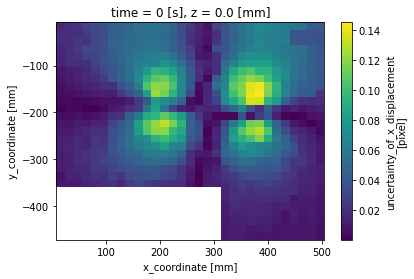

In [13]:
with H5PIV(h5.hdf_filename, 'r+') as h5:
    h5.dump()
    h5.uncertainty.delta_dx[:,:].plot()